In [1]:
import numpy as np
import pandas as pd
import os

import re
from datetime import datetime as time
from ast import literal_eval
from sklearn.model_selection import train_test_split

import artm
from gensim.models import Phrases
from gensim.models.phrases import Phraser

import gc
import matplotlib.pyplot as plt
%matplotlib inline

/home/vtrokhymenko/proj_news_viz/env4news/lib/python3.6/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [2]:
!ls -lah data/*.csv.bz2

-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 491K Jan 15 18:18 data/69-.paralel.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  48M Jan 15 18:21 data/Russia.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  12M Jan 15 18:21 data/Sil_struktur.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  44K Jan 15 18:19 data/biblioteka.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  25M Jan 15 18:19 data/bivs.SSR.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 6.1M Jan 15 18:18 data/biznes.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 2.9M Jan 15 18:21 data/cennosti.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  28M Jan 15 18:21 data/economic.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  16M Jan 15 18:19 data/internet.i.smi.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 8.6M Jan 15 18:18 data/iz.jizni.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 125K Jan 15 18:18 data/kultprosvet.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  20M Jan 15 18:18 data/kultura.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 

In [3]:
name_dataset = 'bivs.SSR'

### load data

In [4]:
%%time
df = pd.read_csv(f'data/{name_dataset}.csv.bz2')
print(df.shape)

(61056, 7)
CPU times: user 6.98 s, sys: 151 ms, total: 7.13 s
Wall time: 7.14 s


In [5]:
df = df[df.text!='text']
df.head(2)

,1914-lenta/,url,edition,topics,title,text,topic
0,1999-10-01 12:00:00,https://lenta.ru/news/1999/10/01/azerbaijan/,NaN,Россия,Российский самолет сбросил бомбу на Азербайджан,ИТАР-ТАСС со ссылкой на пресс-службу Миноборон...,Бывший СССР
1,1999-10-01 12:00:00,https://lenta.ru/news/1999/10/01/minsk/,NaN,Мир,В Минске прошла массовая акция протеста,В минувший четверг в Минске прошла самая массо...,Бывший СССР


### preprocess

* get dates

In [6]:
%%time

df['date_raw'] = df['url'].apply(re.compile('(\d{4})/(\d{2})/(\d{2})').findall)

df['year'] = df['date_raw'].apply(lambda x: int(x[0][0]))
df['month'] = df['date_raw'].apply(lambda x: int(x[0][1]))

CPU times: user 227 ms, sys: 7.91 ms, total: 235 ms
Wall time: 234 ms


<unknown>:2: DeprecationWarning: invalid escape sequence \d


* clean text

In [7]:
import preprocessing_tools as pr

In [8]:
%%time
df.text = df.text.apply(pr.clean_text)

CPU times: user 10.1 s, sys: 50.1 ms, total: 10.2 s
Wall time: 10.2 s


In [9]:
df.head(2)

,1914-lenta/,url,edition,topics,title,text,topic,date_raw,year,month
0,1999-10-01 12:00:00,https://lenta.ru/news/1999/10/01/azerbaijan/,NaN,Россия,Российский самолет сбросил бомбу на Азербайджан,итартасс со ссылкой на прессслужбу минобороны ...,Бывший СССР,"[(1999, 10, 01)]",1999,10
1,1999-10-01 12:00:00,https://lenta.ru/news/1999/10/01/minsk/,NaN,Мир,В Минске прошла массовая акция протеста,в минувший четверг в минске прошла самая массо...,Бывший СССР,"[(1999, 10, 01)]",1999,10


* cleanedNames

In [10]:
from cleanedNames import KeyProc
cn = KeyProc()

In [11]:
%%time
df.text = df.text.apply(cn.replaceKeywords)

CPU times: user 1min 42s, sys: 8.66 ms, total: 1min 42s
Wall time: 1min 42s


* lemmatization

In [12]:
%%time
df['lemmatized_text'] = df.text.apply(pr.lemmatization)

CPU times: user 2min 30s, sys: 201 ms, total: 2min 30s
Wall time: 2min 30s


* add docID

In [13]:
df['docID'] = list(range(df.shape[0]))

In [14]:
df = df[['docID','year','month','lemmatized_text']]
df.head(2)

,docID,year,month,lemmatized_text
0,0,1999,10,"[итартасс, ссылка, прессслужба, минобороны, аз..."
1,1,1999,10,"[минувший, четверг, минск, пройти, самый, масс..."


In [15]:
print(df.shape)
df.isnull().sum()

(61056, 4)


docID              0
year               0
month              0
lemmatized_text    0
dtype: int64

In [16]:
df.year.min()

1999

## model

* prepare

In [17]:
%%time

vwpath = f'data/vwpath/{name_dataset}_input_bigartm.vw'

with open(vwpath, 'w') as fp:
    for text, did in df[['lemmatized_text', 'docID']].values:
        fp.write('{} | {}\n'.format(did, ' '.join(text)))

CPU times: user 630 ms, sys: 120 ms, total: 750 ms
Wall time: 749 ms


In [18]:
id_date = df[['docID', 'year', 'month']].copy()

* collect batchs and collect the dictionary

In [19]:
%%time

batches_path = f'data/batches/{name_dataset}'

if not os.path.exists(batches_path):
    print('create folder...\n')
    os.makedirs(batches_path)
    
batch_vectorizer = artm.BatchVectorizer(data_path=vwpath,
                                        data_format='vowpal_wabbit',
                                        target_folder=batches_path)

print(batch_vectorizer)

create folder...

artm.BatchVectorizer(data_path="data/batches/bivs.SSR", num_batches=62)
CPU times: user 28.5 s, sys: 552 ms, total: 29 s
Wall time: 5.56 s


In [20]:
dictionary = artm.Dictionary()
dictionary.gather(data_path=batches_path)

In [21]:
dictionary.filter(min_tf=10, max_df_rate=0.1) #int(4.5e5)

artm.Dictionary(name=f026d16b-893f-4c0a-856b-93a80970e264, num_entries=24220)

In [22]:
dictionary.save_text(f'data/dicts/dict_{name_dataset}.txt')

## pick up amount topics

In [23]:
%%time
model_list = []
step, perplexity, sTheta, sPhi = [], [], [], []

for i in range(2,20+1,1):
    print(f'#topic {i}.........')
    step.append(i)
    date_start = time.now()
    
    num_topics = i
    model = artm.ARTM(num_topics=num_topics, dictionary=dictionary)
    
    # scores
    model.scores.add(artm.PerplexityScore(name='PerplexityScore',dictionary=dictionary))
    model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
    model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))

    # regularizers
    model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1))
    model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.5))
    model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5))
    
    model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=50)
    model_list.append(model)
    
    sparsityTheta = model.score_tracker['SparsityThetaScore'].last_value
    sTheta.append(sparsityTheta)
    sparsityPhi = model.score_tracker['SparsityPhiScore'].last_value
    sPhi.append(sparsityPhi)
    perpl = model.score_tracker['PerplexityScore'].last_value
    perplexity.append(perpl)
    
    print(f'\tSparsityThetaScore: {sparsityTheta}')
    print(f'\tSparsityPhiScore: {sparsityPhi}')
    print(f'\tPerplexityScore: {perpl}')
    
    print('\ttime:',time.now()-date_start)
    
newTime = time.now() #

#topic 2.........
	SparsityThetaScore: 0.1356705278158188
	SparsityPhiScore: 0.23542526364326477
	PerplexityScore: 4328.91259765625
	time: 0:00:42.891542
#topic 3.........
	SparsityThetaScore: 0.23013845086097717
	SparsityPhiScore: 0.39057251811027527
	PerplexityScore: 4002.4677734375
	time: 0:00:44.776075
#topic 4.........
	SparsityThetaScore: 0.31937482953071594
	SparsityPhiScore: 0.4670107364654541
	PerplexityScore: 3681.4736328125
	time: 0:00:59.868163
#topic 5.........
	SparsityThetaScore: 0.39077240228652954
	SparsityPhiScore: 0.5273492932319641
	PerplexityScore: 3501.834716796875
	time: 0:01:10.202672
#topic 6.........
	SparsityThetaScore: 0.4416164457798004
	SparsityPhiScore: 0.5722199082374573
	PerplexityScore: 3310.90185546875
	time: 0:01:13.055424
#topic 7.........
	SparsityThetaScore: 0.48344144225120544
	SparsityPhiScore: 0.61482834815979
	PerplexityScore: 3177.38330078125
	time: 0:01:17.650177
#topic 8.........
	SparsityThetaScore: 0.5216993689537048
	SparsityPhiScore: 0.

In [31]:
#model_list

Text(0.5, 1.0, 'SparsityPhiScore')

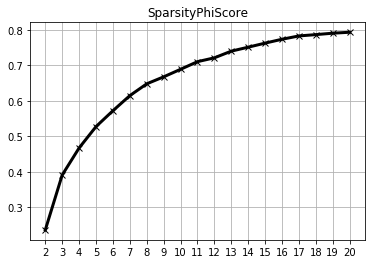

In [33]:
plt.plot(step, sPhi, color='k',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()
plt.title('SparsityPhiScore')

In [34]:
index_sphi = []
[index_sphi.append(float(str(i)[:3]) ) for i in sPhi]
    
index_sphi = list(set(index_sphi))
index_sphi.sort()
index_sphi

[0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

In [35]:
d_sphi = {}

for j in range(len(index_sphi)):
    k=0
    for i in sPhi:
        if j==range(len(index_sphi))[-1]:
            if (i>=index_sphi[j]):
                k+=1
        else:
            if (i>=index_sphi[j]) & (i<index_sphi[j+1]):
                k+=1
    d_sphi[index_sphi[j]]=k

d_sphi

{0.2: 1, 0.3: 1, 0.4: 1, 0.5: 2, 0.6: 4, 0.7: 10}

Text(0.5, 1.0, 'SparsityThetaScore')

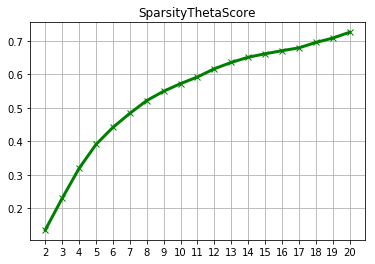

In [36]:
plt.plot(step, sTheta, color='g',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()

plt.title('SparsityThetaScore')

In [37]:
index_theta = []
[index_theta.append(float(str(i)[:3])) for i in sTheta]
    
index_theta = list(set(index_theta))
index_theta.sort()
index_theta

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

In [38]:
d_stheta = {}

for j in range(len(index_theta)):
    k=0
    for i in sTheta:
        if j==range(len(index_theta))[-1]:
            if (i>=index_theta[j]):
                k+=1
        else:
            if (i>=index_theta[j]) & (i<index_theta[j+1]):
                k+=1
    d_stheta[index_theta[j]]=k

d_stheta

{0.1: 1, 0.2: 1, 0.3: 2, 0.4: 2, 0.5: 4, 0.6: 7, 0.7: 2}

Text(0.5, 1.0, 'PerplexityScore')

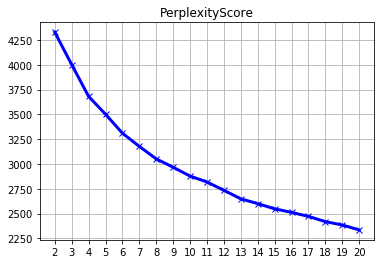

In [39]:
plt.plot(step, perplexity, color='b',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()
plt.title('PerplexityScore')

In [40]:
perplexity

[4328.91259765625,
 4002.4677734375,
 3681.4736328125,
 3501.834716796875,
 3310.90185546875,
 3177.38330078125,
 3051.691650390625,
 2967.643310546875,
 2878.2666015625,
 2818.849853515625,
 2734.997802734375,
 2649.097412109375,
 2600.837646484375,
 2548.34619140625,
 2512.116455078125,
 2472.227294921875,
 2419.25390625,
 2385.241943359375,
 2335.58740234375]

### select the best model

In [42]:
print(f'd_sphi:   {d_sphi}')
print(f'd_stheta: {d_stheta}')

d_sphi:   {0.2: 1, 0.3: 1, 0.4: 1, 0.5: 2, 0.6: 4, 0.7: 10}
d_stheta: {0.1: 1, 0.2: 1, 0.3: 2, 0.4: 2, 0.5: 4, 0.6: 7, 0.7: 2}


In [43]:
select_topics = 20 # u should choose number of topic

best_model = model_list[select_topics-2]
print(best_model.num_topics)

20


### print top words for each topics

In [44]:
phi = best_model.get_phi()
phi['word'] = phi.index
#phi.head()

for col in phi.columns:
    if col != 'word':
        print(f"{col}: {phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:10]}")
        #print('\t',phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:10])

topic_0: ['миллион' 'компания' 'миллиард' 'гривна' 'средство' 'деньга'
 'предприятие' 'сумма' 'процент' 'газа']
topic_1: ['митинг' 'участник' 'оппозиция' 'протест' 'активист' 'беспорядок'
 'сторонник' 'массовый' 'площадь' 'майдан']
topic_2: ['донецкий' 'донбасс' 'луганский' 'днр' 'самопровозгласить' 'ополченец'
 'донецк' 'лнр' 'операция' 'огонь']
topic_3: ['сша' 'молдавия' 'нато' 'встреча' 'американский' 'переговоры'
 'сотрудничество' 'визит' 'молдавский' 'приднестровье']
topic_4: ['эстония' 'литва' 'мид' 'ес' 'посольство' 'евросоюз' 'эстонский'
 'соглашение' 'режим' 'иностранный']
topic_5: ['грузинский' 'абхазия' 'южный' 'осетия' 'тбилиси' 'михаил_саакашвили'
 'саакашвили' 'миротворец' 'абхазский' 'зона']
topic_6: ['белоруссия' 'белорусский' 'граница' 'самолёт' 'минск' 'лукашенко'
 'пограничник' 'александр_лукашенко' 'пограничный' 'аэропорт']
topic_7: ['погибший' 'больница' 'тело' 'журналист' 'врач' 'расследование' 'причина'
 'погибнуть' 'смерть' 'состояние']
topic_8: ['крым' 'латвия'

### get topics-docs matrix

shape theta: (20, 61056)


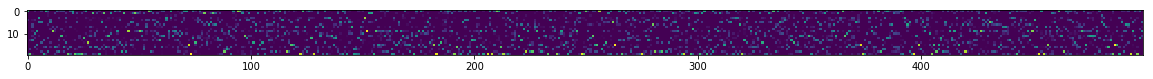

In [45]:
theta = best_model.transform_sparse(batch_vectorizer=batch_vectorizer, eps=0.001)
print(f'shape theta: {theta[0].shape}')

plt.figure(figsize=(20, 20))
plt.imshow(theta[0][:, 2000:2500].toarray());

### dense theta matrix

In [46]:
theta = best_model.transform(batch_vectorizer=batch_vectorizer)
theta = theta.T
theta.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
16000,0.160451,0.0,0.0,0.276962,0.015851,0.000000,0.227752,0.000000,0.0,0.000000,0.000000,0.00000,0.025471,0.000000,0.000000,0.000000,0.000000,0.293513,0.0,0.000000
16001,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.066069,0.000000,0.00000,0.000000,0.000000,0.000000,0.573788,0.360142,0.000000,0.0,0.000000
16002,0.000000,0.0,0.0,0.000000,0.028436,0.721258,0.064695,0.000000,0.0,0.000000,0.014582,0.00000,0.000000,0.171027,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
16003,0.320891,0.0,0.0,0.383129,0.071788,0.000000,0.200330,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.023862,0.000000,0.000000,0.000000,0.0,0.000000
16004,0.000000,0.0,0.0,0.333171,0.000000,0.000000,0.000000,0.040244,0.0,0.000000,0.000000,0.39481,0.000000,0.000000,0.000000,0.000000,0.142219,0.000000,0.0,0.089556


## DataViz

In [47]:
joined = id_date.join(theta)
joined.head()

,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,0,1999,10,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.282373,...,0.00000,0.000000,0.000000,0.0,0.247483,0.289323,0.000000,0.180822,0.0,0.000000
1,1,1999,10,0.317077,0.261897,0.0,0.065343,0.0,0.0,0.114105,...,0.00000,0.000000,0.241578,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
2,2,1999,10,0.134619,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.00000,0.000000,0.000000,0.0,0.000000,0.747613,0.000000,0.000000,0.0,0.000000
3,3,1999,10,0.066729,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.04492,0.025879,0.032298,0.0,0.000000,0.188238,0.028452,0.000000,0.0,0.416117
4,4,1999,10,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.357588,...,0.00000,0.000000,0.015023,0.0,0.029986,0.597403,0.000000,0.000000,0.0,0.000000


In [48]:
topics = ['topic_{}'.format(i) for i in range(select_topics)]
gb = joined.groupby(['year', 'month'])[topics].sum()
print(f'gb.shape: {gb.shape}')
gb.head()

gb.shape: (228, 20)


topic_0   topic_1   topic_2   topic_3   topic_4   topic_5  \
year month                                                               
1999 8      0.000000  0.427457  0.000000  0.079485  0.395960  0.000000   
     9      2.654833  0.739980  0.283682  2.409417  0.453540  0.529206   
     10     6.230603  2.046548  0.489505  6.906397  1.953317  2.470384   
     11     6.140048  0.828441  0.138250  6.056138  1.573879  2.709821   
     12     5.545222  1.050135  0.040479  5.532717  2.823852  2.720562   

             topic_6   topic_7   topic_8   topic_9  topic_10  topic_11  \
year month                                                               
1999 8      0.000000  0.055612  0.236095  0.037763  0.108385  0.153720   
     9      1.783761  0.754675  0.270789  0.917061  0.975636  0.328241   
     10     3.499259  1.838983  1.307520  4.210508  2.114866  1.117716   
     11     3.147352  1.233315  1.163750  3.910822  3.159550  1.791260   
     12     4.276641  1.405009  0.591194  1.871397  2.168817  1.393246   

            topic_12  topic_13  topic_14   topic_15  topic_16  topic_17  \
year month                                                                
1999 8      0.114478  0.465126  0.102589   0.660179  0.000000  0.163151   
     9      0.249370  0.455962  2.527998   7.131903  0.997591  0.664419   
     10     2.652573  2.188194  2.120678  10.746339  2.646161  1.609469   
     11     0.984054  3.333900  2.389917   7.015553  1.630907  1.689870   
     12     1.488395  4.111588  1.283904   6.440327  3.793327  0.844180   

            topic_18  topic_19  
year month                      
1999 8      0.000000  0.000000  
     9      1.230519  0.641418  
     10     3.584934  4.266046  
     11     4.452037  7.651134  
     12     3.203419  6.415589

### straightforward matrix heatmap

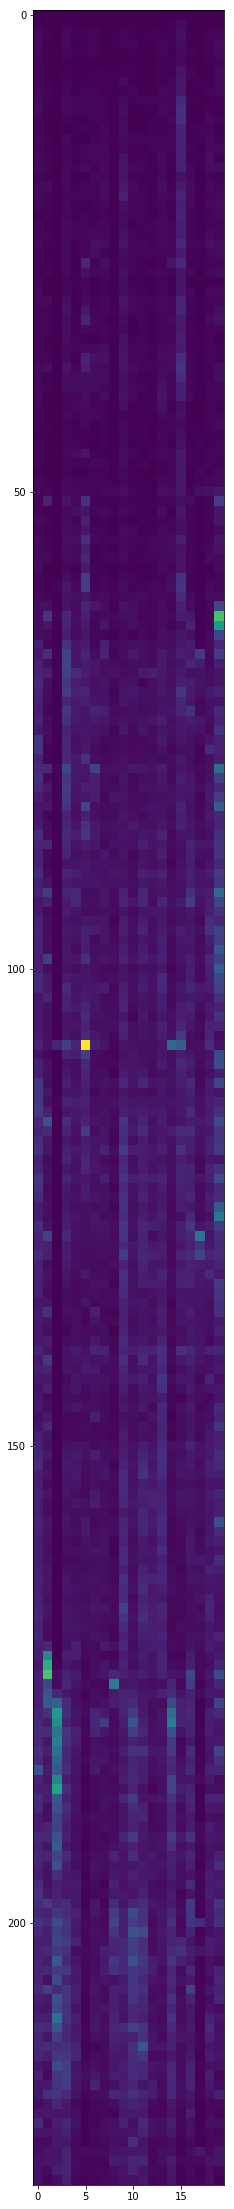

In [49]:
plt.figure(figsize=(10, 40))
plt.imshow(gb[topics])

## pygal

In [50]:
import pygal
from IPython.display import SVG, HTML

In [51]:
html_pygal = """
<!DOCTYPE html>
<html>
  <head>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/svg.jquery.js"></script>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/pygal-tooltips.js"></script>
    <!-- ... -->
  </head>
  <body>
    <figure>
      {pygal_render}
    </figure>
  </body>
</html>
"""

In [73]:
max(gb['topic_1'].values)

178.77971

In [ ]:
line_chart = pygal.StackedLine(fill=True, show_dots=False)
line_chart.title = 'Topics'
for topic in topics:
    line_chart.add(topic, gb[topic].values)
    
HTML(html_pygal.format(pygal_render=line_chart.render(is_unicode=True)))

In [53]:
line_chart.render_to_file(f"data/visualization/{'-'.join(name_dataset.split('.'))}_pygal.svg")

## joypy

In [54]:
import joypy # !pip install joypy

In [55]:
print(joined.shape)
joined.head()

(61056, 23)


,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,0,1999,10,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.282373,...,0.00000,0.000000,0.000000,0.0,0.247483,0.289323,0.000000,0.180822,0.0,0.000000
1,1,1999,10,0.317077,0.261897,0.0,0.065343,0.0,0.0,0.114105,...,0.00000,0.000000,0.241578,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
2,2,1999,10,0.134619,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.00000,0.000000,0.000000,0.0,0.000000,0.747613,0.000000,0.000000,0.0,0.000000
3,3,1999,10,0.066729,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.04492,0.025879,0.032298,0.0,0.000000,0.188238,0.028452,0.000000,0.0,0.416117
4,4,1999,10,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.357588,...,0.00000,0.000000,0.015023,0.0,0.029986,0.597403,0.000000,0.000000,0.0,0.000000


In [56]:
joined['year_month'] = joined.apply(lambda x: str(int(x.year)) +'-'+ str(int(x.month)) + '-01', axis=1)
joined.reset_index(inplace=True)

joined.head()

,index,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,year_month
0,0,0,1999,10,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.247483,0.289323,0.000000,0.180822,0.0,0.000000,1999-10-01
1,1,1,1999,10,0.317077,0.261897,0.0,0.065343,0.0,0.0,...,0.000000,0.241578,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1999-10-01
2,2,2,1999,10,0.134619,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.747613,0.000000,0.000000,0.0,0.000000,1999-10-01
3,3,3,1999,10,0.066729,0.000000,0.0,0.000000,0.0,0.0,...,0.025879,0.032298,0.0,0.000000,0.188238,0.028452,0.000000,0.0,0.416117,1999-10-01
4,4,4,1999,10,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.015023,0.0,0.029986,0.597403,0.000000,0.000000,0.0,0.000000,1999-10-01


In [57]:
joined_melt = joined.melt('year_month', var_name='topic', value_name='text')
print(joined_melt.shape)
joined_melt.head()

(1465344, 3)


,year_month,topic,text
0,1999-10-01,index,0.0
1,1999-10-01,index,1.0
2,1999-10-01,index,2.0
3,1999-10-01,index,3.0
4,1999-10-01,index,4.0


In [58]:
# select only topic_*
joined_melt_new = joined_melt[(joined_melt.topic!='docID') & (joined_melt.topic!='index')
                              & (joined_melt.topic!='year') & (joined_melt.topic!='month')]
print(joined_melt_new.shape)
joined_melt_new.topic.value_counts()

(1221120, 3)


topic_14    61056
topic_6     61056
topic_2     61056
topic_17    61056
topic_10    61056
topic_8     61056
topic_0     61056
topic_5     61056
topic_15    61056
topic_3     61056
topic_18    61056
topic_9     61056
topic_4     61056
topic_19    61056
topic_1     61056
topic_7     61056
topic_11    61056
topic_16    61056
topic_12    61056
topic_13    61056
Name: topic, dtype: int64

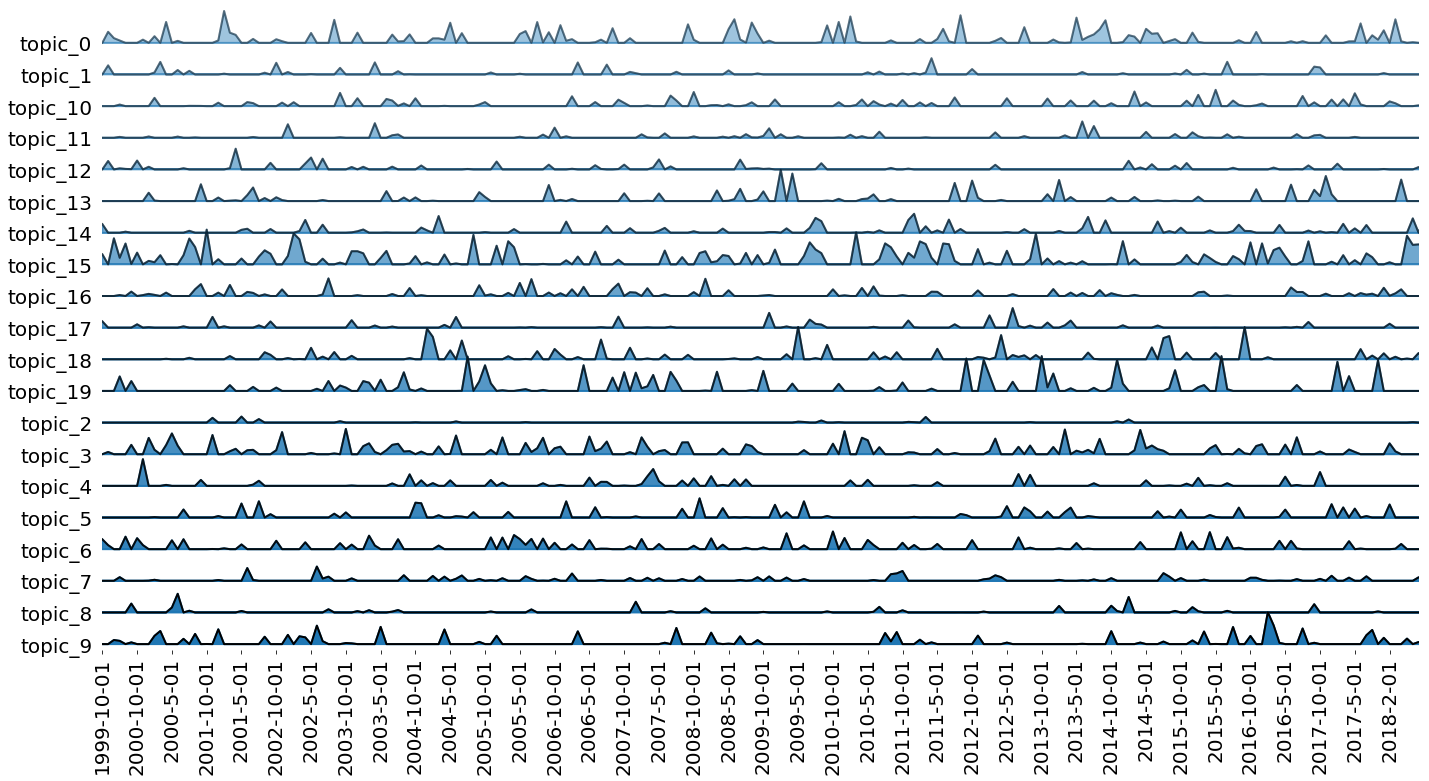

In [59]:
labels = sorted(joined_melt_new['year_month'].unique())

fig, axes = joypy.joyplot(joined_melt_new, by='topic', column='text', figsize=(20, 10),xlabelsize=20,ylabelsize=20,
                          overlap=0.4, fill=True, linecolor="k", linewidth=2,
                          kind='values', fade=True, xrot=90, x_range=[i for i in range(len(labels))],
                          background='white');

ticks_labels = {i:t for i, t in enumerate(labels)}
axes[-1].set_xticks([k for k, v in ticks_labels.items() if k % 6 == 0])
ticks = axes[-1].get_xticks()
axes[-1].set_xticklabels([ticks_labels.get(i, 'stop') for i in ticks]);

In [60]:
fig.savefig(f"data/visualization/{'-'.join(name_dataset.split('.'))}_joypy")